## Feature Extraction



Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]
Matrix W:
 [[-0.13724218 -0.50303478]
 [ 0.24724326 -0.16487119]
 [-0.02545159 -0.24456476]
 [ 0.20694508  0.11352904]
 [-0.15436582 -0.28974518]
 [-0.39376952 -0.05080104]
 [-0.41735106  0.02287338]
 [ 0.30572896 -0.09048885]
 [-0.30668347 -0.00835233]
 [ 0.07554066 -0.54977581]
 [-0.32613263  0.20716433]
 [-0.36861022  0.24902536]
 [-0.29669651 -0.38022942]]


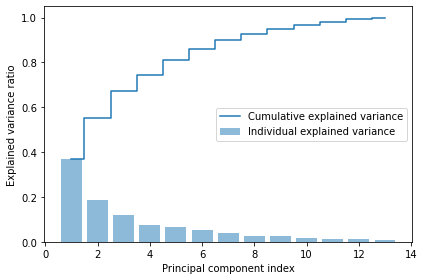

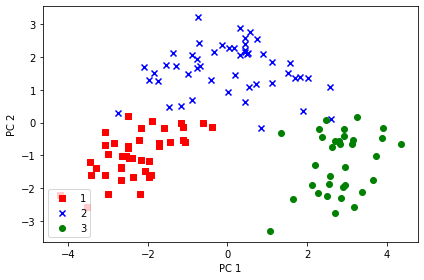

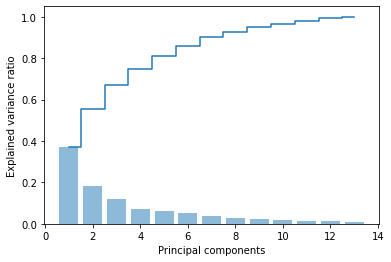

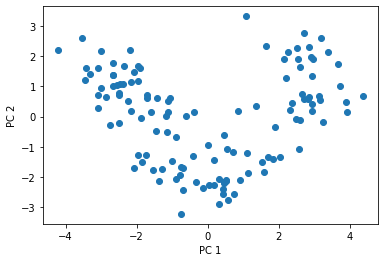

In [1]:
# coding: utf-8


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version
from numpy import exp
from scipy import exp
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.decomposition import KernelPCA

# *Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2019
#
# Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition
#
# Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# # Python Machine Learning - Code Examples

# # Chapter 5 - Compressing Data via Dimensionality Reduction

# Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).





# *The use of `watermark` is optional. You can install this Jupyter extension via*
#
#     conda install watermark -c conda-forge
#
# or
#
#     pip install watermark
#
# *For more information, please see: https://github.com/rasbt/watermark.*


# ### Overview

# - [Unsupervised dimensionality reduction via principal component analysis 128](#Unsupervised-dimensionality-reduction-via-principal-component-analysis-128)
#   - [The main steps behind principal component analysis](#The-main-steps-behind-principal-component-analysis)
#   - [Extracting the principal components step-by-step](#Extracting-the-principal-components-step-by-step)
#   - [Total and explained variance](#Total-and-explained-variance)
#   - [Feature transformation](#Feature-transformation)
#   - [Principal component analysis in scikit-learn](#Principal-component-analysis-in-scikit-learn)
# - [Supervised data compression via linear discriminant analysis](#Supervised-data-compression-via-linear-discriminant-analysis)
#   - [Principal component analysis versus linear discriminant analysis](#Principal-component-analysis-versus-linear-discriminant-analysis)
#   - [The inner workings of linear discriminant analysis](#The-inner-workings-of-linear-discriminant-analysis)
#   - [Computing the scatter matrices](#Computing-the-scatter-matrices)
#   - [Selecting linear discriminants for the new feature subspace](#Selecting-linear-discriminants-for-the-new-feature-subspace)
#   - [Projecting examples onto the new feature space](#Projecting-examples-onto-the-new-feature-space)
#   - [LDA via scikit-learn](#LDA-via-scikit-learn)
# - [Using kernel principal component analysis for nonlinear mappings](#Using-kernel-principal-component-analysis-for-nonlinear-mappings)
#   - [Kernel functions and the kernel trick](#Kernel-functions-and-the-kernel-trick)
#   - [Implementing a kernel principal component analysis in Python](#Implementing-a-kernel-principal-component-analysis-in-Python)
#     - [Example 1 – separating half-moon shapes](#Example-1:-Separating-half-moon-shapes)
#     - [Example 2 – separating concentric circles](#Example-2:-Separating-concentric-circles)
#   - [Projecting new data points](#Projecting-new-data-points)
#   - [Kernel principal component analysis in scikit-learn](#Kernel-principal-component-analysis-in-scikit-learn)
# - [Summary](#Summary)






# # Unsupervised dimensionality reduction via principal component analysis

# ## The main steps behind principal component analysis





# ## Extracting the principal components step-by-step




df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()



# Splitting the data into 70% training and 30% test subsets.




X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =     train_test_split(X, y, test_size=0.3,
                     stratify=y,
                     random_state=0)


# Standardizing the data.




sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


# ---
#
# **Note**
#
# Accidentally, I wrote `X_test_std = sc.fit_transform(X_test)` instead of `X_test_std = sc.transform(X_test)`. In this case, it wouldn't make a big difference since the mean and standard deviation of the test set should be (quite) similar to the training set. However, as remember from Chapter 3, the correct way is to re-use parameters from the training set if we are doing any kind of transformation -- the test set should basically stand for "new, unseen" data.
#
# My initial typo reflects a common mistake is that some people are *not* re-using these parameters from the model training/building and standardize the new data "from scratch." Here's simple example to explain why this is a problem.
#
# Let's assume we have a simple training set consisting of 3 examples with 1 feature (let's call this feature "length"):
#
# - train_1: 10 cm -> class_2
# - train_2: 20 cm -> class_2
# - train_3: 30 cm -> class_1
#
# mean: 20, std.: 8.2
#
# After standardization, the transformed feature values are
#
# - train_std_1: -1.21 -> class_2
# - train_std_2: 0 -> class_2
# - train_std_3: 1.21 -> class_1
#
# Next, let's assume our model has learned to classify examples with a standardized length value < 0.6 as class_2 (class_1 otherwise). So far so good. Now, let's say we have 3 unlabeled data points that we want to classify:
#
# - new_4: 5 cm -> class ?
# - new_5: 6 cm -> class ?
# - new_6: 7 cm -> class ?
#
# If we look at the "unstandardized "length" values in our training datast, it is intuitive to say that all of these examples are likely belonging to class_2. However, if we standardize these by re-computing standard deviation and and mean you would get similar values as before in the training set and your classifier would (probably incorrectly) classify examples 4 and 5 as class 2.
#
# - new_std_4: -1.21 -> class 2
# - new_std_5: 0 -> class 2
# - new_std_6: 1.21 -> class 1
#
# However, if we use the parameters from your "training set standardization," we'd get the values:
#
# - example5: -18.37 -> class 2
# - example6: -17.15 -> class 2
# - example7: -15.92 -> class 2
#
# The values 5 cm, 6 cm, and 7 cm are much lower than anything we have seen in the training set previously. Thus, it only makes sense that the standardized features of the "new examples" are much lower than every standardized feature in the training set.
#
# ---

# Eigendecomposition of the covariance matrix.



cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


# **Note**:
#
# Above, I used the [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) function to decompose the symmetric covariance matrix into its eigenvalues and eigenvectors.
#     <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
#     This is not really a "mistake," but probably suboptimal. It would be better to use [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) in such cases, which has been designed for [Hermetian matrices](https://en.wikipedia.org/wiki/Hermitian_matrix). The latter always returns real  eigenvalues; whereas the numerically less stable `np.linalg.eig` can decompose nonsymmetric square matrices, you may find that it returns complex eigenvalues in certain cases. (S.R.)
#


# ## Total and explained variance



tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)






plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()



# ## Feature transformation



# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)




w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)


# **Note**
# Depending on which version of NumPy and LAPACK you are using, you may obtain the Matrix W with its signs flipped. Please note that this is not an issue: If $v$ is an eigenvector of a matrix $\Sigma$, we have
#
# $$\Sigma v = \lambda v,$$
#
# where $\lambda$ is our eigenvalue,
#
#
# then $-v$ is also an eigenvector that has the same eigenvalue, since
# $$\Sigma \cdot (-v) = -\Sigma v = -\lambda v = \lambda \cdot (-v).$$



X_train_std[0].dot(w)




X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
                X_train_pca[y_train == l, 1],
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_03.png', dpi=300)
plt.show()



# ## Principal component analysis in scikit-learn

# **NOTE**
#
# The following four code cells has been added in addition to the content to the book, to illustrate how to replicate the results from our own PCA implementation in scikit-learn:




pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_




plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()




pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)




plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()





def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.6,
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl)


# Training logistic regression classifier using the first 2 principal components.




pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

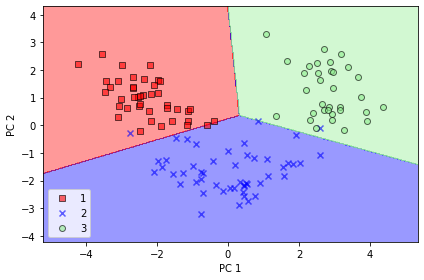

In [2]:

plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

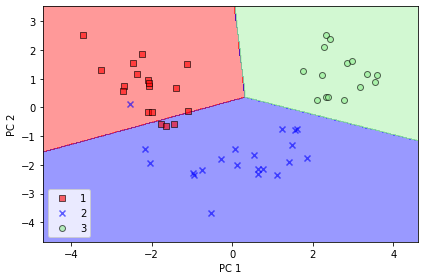

In [3]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_05.png', dpi=300)
plt.show()

In [4]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_



array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

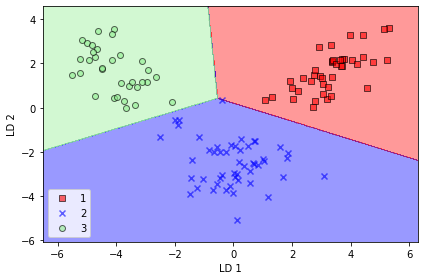

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda=lda.fit_transform(X_train_std,y_train)
lr = LogisticRegression(multi_class='ovr',random_state=1,solver='lbfgs')
lr = lr.fit(X_train_lda,y_train)
plot_decision_regions(X_train_lda,y_train,
                      classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

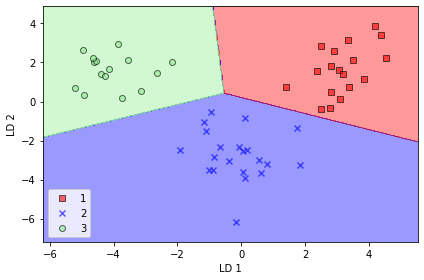

In [8]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda,y_test,classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


## kernel PCA


In [ ]:
from scipy.spatial.distance import pdist,squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np